回测平台

    INFO - 模拟交易下单 TQSIM, PYSDK_target_7d83c1b7538047a151e94d2b2ba13e60: 时间: 2023-03-14 14:59:00.000000, 合约: DCE.j2307, 开平: OPEN, 方向: BUY, 手数: 11, 价格: 2932.5
    INFO - 模拟交易委托单 TQSIM, PYSDK_target_7d83c1b7538047a151e94d2b2ba13e60: 全部成交
    INFO - 模拟交易下单 TQSIM, PYSDK_target_c289ceddceaa8b7fe53d61d1d25ea4c3: 时间: 2023-03-14 14:59:00.000000, 合约: DCE.jm2307, 开平: OPEN, 方向: SELL, 手数: 42, 价格: 1933.5
    INFO - 模拟交易委托单 TQSIM, PYSDK_target_c289ceddceaa8b7fe53d61d1d25ea4c3: 全部成交
    INFO - 模拟交易下单 TQSIM, PYSDK_target_5881850262f67ded28b4b6e853dc8192: 时间: 2023-03-15 14:59:00.000000, 合约: DCE.j2307, 开平: CLOSE, 方向: SELL, 手数: 11, 价格: 2805.0
    INFO - 模拟交易委托单 TQSIM, PYSDK_target_5881850262f67ded28b4b6e853dc8192: 全部成交
    INFO - 模拟交易下单 TQSIM, PYSDK_target_b729daf60c917d0a79edbdc95b8e9738: 时间: 2023-03-15 14:59:00.000000, 合约: DCE.jm2307, 开平: CLOSE, 方向: BUY, 手数: 42, 价格: 1880.5
    INFO - 模拟交易委托单 TQSIM, PYSDK_target_b729daf60c917d0a79edbdc95b8e9738: 全部成交
    INFO - 模拟交易下单 TQSIM, PYSDK_target_fed1defdbbfa8e33

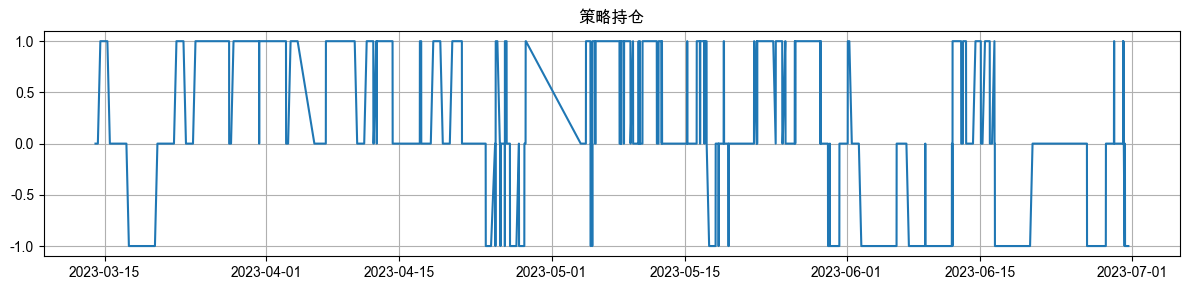

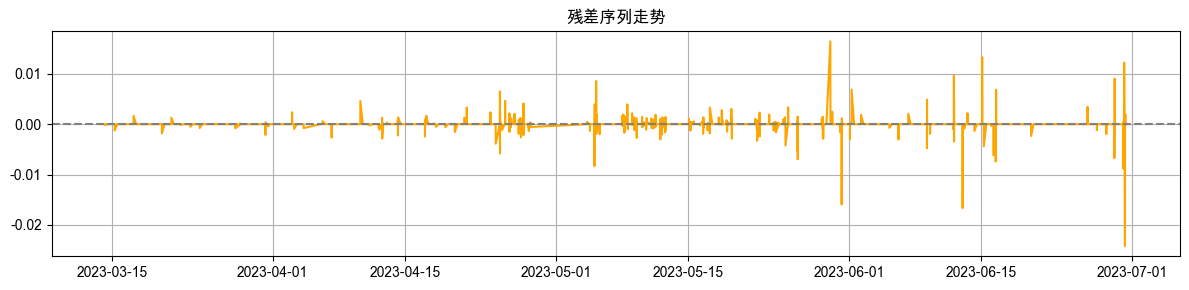

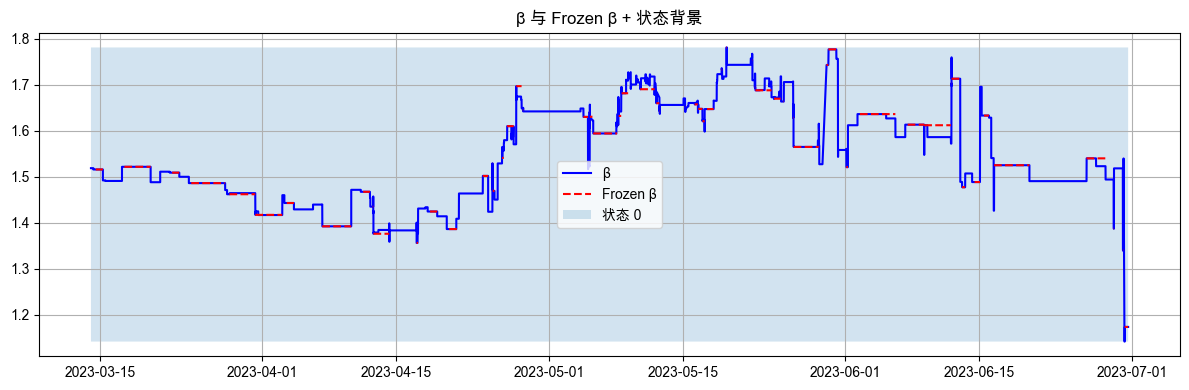

In [20]:
import numpy as np
import pandas as pd
from collections import deque
from hmmlearn.hmm import GaussianHMM
from datetime import date, timedelta
from scipy.stats.mstats import winsorize
from tqsdk import TqApi, TqAuth, TqBacktest, BacktestFinished, TargetPosTask
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Arial Unicode MS'  
# plt.rcParams['font.family'] = 'SimHei'    
plt.rcParams['axes.unicode_minus'] = False  


#参数
SYMBOL_Y = "DCE.j2307"
SYMBOL_X = "DCE.jm2307"
OBS_VAR = 0.01
STATE_VAR = 0.0001
STD_WINDOW = 90
MIN_POINTS = 10
N_COMPONENTS = 3
HMM_DAYS = 10
STOP_SPREAD = 1.0
BETA_DIFF_THRESH = 0.02
INIT_CAP = 1_000_000
POS_PCT = 0.2

#Kalman Filter and Z-score
class KalmanResidualEstimator:
    """只估计beta和残差，不做标准化"""
    def __init__(self, obs_var=OBS_VAR, state_var=STATE_VAR, init_mean=1.0, init_var=1.0, std_window=90):
        self.obs_var = obs_var
        self.state_var = state_var
        self.mean = init_mean
        self.var = init_var
        self.residuals = deque(maxlen=std_window)

    def step(self, y, x):
        pred_mean = self.mean
        pred_var = self.var + self.state_var
        k_gain = pred_var * x / (pred_var * x ** 2 + self.obs_var)
        self.mean = pred_mean + k_gain * (y - pred_mean * x)
        self.var = (1 - k_gain * x) * pred_var
        return self.mean
    
    def update_residual(self, y, x, use_beta=None):
        beta = use_beta if use_beta is not None else self.step(y, x)
        residual = y - beta * x
        self.residuals.append(residual)
        return residual, beta
    
#训练HMM
def train_hmm_model(df, n_components=N_COMPONENTS):
    df = df.copy()
    df['Minute'] = df['datetime'].dt.floor("min")
    dfm = df.groupby('Minute').first().reset_index()
    kf = KalmanResidualEstimator(init_mean=dfm.iloc[0]["close_y"] / dfm.iloc[0]["close_x"])

    residuals = []
    for _, row in dfm.iterrows():
        res, _ = kf.update_residual(row["close_y"], row["close_x"])
        residuals.append(res)
        
    residuals = [r for r in residuals if not np.isnan(r)]
    if len(residuals) < MIN_POINTS:
        return None
    
    model = GaussianHMM(n_components=n_components, covariance_type="full", n_iter=100)
    model.fit(np.array(residuals).reshape(-1, 1))
    return model
    
#提取HMM不同状态残差分布
def get_state_stats(model, df):
    df = df.copy()
    df['Minute'] = df['datetime'].dt.floor("min")
    dfm = df.groupby('Minute').first().reset_index()
    kf = KalmanResidualEstimator(init_mean=dfm.iloc[0]["close_y"] / dfm.iloc[0]["close_x"])
    dfm["residual"] = [kf.update_residual(row["close_y"], row["close_x"])[0] for _, row in dfm.iterrows()]
    states = model.predict(dfm["residual"].values.reshape(-1, 1))
    dfm["state"] = states
    state_stats = {}
    for s in range(model.n_components):
        res = dfm[dfm["state"] == s]["residual"]
        if len(res) < 5:
            continue
        state_stats[s] = {
            "std": np.std(res),
            "quantiles": {
                "p0.1": np.percentile(res, 0.1),
                "p1": np.percentile(res, 1),
                "p40": np.percentile(res, 40),
                "p60": np.percentile(res, 60),
                "p99": np.percentile(res, 99),
                "p99.9": np.percentile(res, 99.9),
            }
        }
    return state_stats

#自适应开仓阈值（这个参数可以调整）
def get_dynamic_threshold(state_stats, state, mode='adaptive', min_range=0.001):
    """
    根据不同状态的波动率自动选取开仓分位数区间，中高波动状态禁止开仓；
    分位数过窄的状态禁止开仓；在后面还给了一个超出阈值，我们不能支持概率开仓
    """
    if state not in state_stats:
        return None, None

    std = state_stats[state]["std"]
    q = state_stats[state]["quantiles"]

    #限制残差宽度，避免窄状态下开仓
    residual_range = q["p99.9"] - q["p0.1"]
    if residual_range < min_range:
        return None, None

    if mode == 'adaptive':
        if std < 1.0:
            return q["p99.9"], q["p0.1"]
        elif std < 2.0:
            return None, None
        else:
            return None, None  #中高波动状态不允许开仓
    else:
        return q["p99"], q["p1"]
    
#主循环流程
#初始化
api = TqApi(backtest=TqBacktest(start_dt=date(2023, 3, 1), end_dt=date(2023, 7, 1)),
            auth=TqAuth("Lawrence-047", "Gzy13802002!"))
quote_y = api.get_quote(SYMBOL_Y)
quote_x = api.get_quote(SYMBOL_X)
klines_y = api.get_kline_serial(SYMBOL_Y, 60)
klines_x = api.get_kline_serial(SYMBOL_X, 60)
target_y = TargetPosTask(api, SYMBOL_Y)
target_x = TargetPosTask(api, SYMBOL_X)

model, state_stats, kf = None, None, None
position = 0
entry_residual, frozen_beta, entry_time = None, None, None
trading_days = set()
state_buffer = deque(maxlen=5)
entry_state, entry_mean, entry_std = None, None, None

#日志记录，后面画图用
log_times = []
log_positions = []
log_residuals = []
log_beta = []
log_frozen_beta = []
log_states = []

try:
    while True:
        api.wait_update()
        if not api.is_changing(klines_y.iloc[-1], "datetime"):
            continue

        now = pd.to_datetime(klines_y.iloc[-1]["datetime"], unit="ns")
        price_y = klines_y.iloc[-1]["close"]
        price_x = klines_x.iloc[-1]["close"]
        today = now.date()
        
        #初始化HMM训练
        if today not in trading_days:
            trading_days.add(today)
            if len(trading_days) == HMM_DAYS:
                history = pd.DataFrame({
                    "datetime": klines_y.datetime / 1e9,
                    "close_y": klines_y.close,
                    "close_x": klines_x.close,
                }).dropna()
                history["datetime"] = pd.to_datetime(history["datetime"], unit="s")
                history = history[history["datetime"].dt.date < today]
                model = train_hmm_model(history)
                if model:
                    state_stats = get_state_stats(model, history)
                kf = KalmanResidualEstimator(init_mean=price_y / price_x)

        if len(trading_days) <= HMM_DAYS:
            continue

        residual, beta = kf.update_residual(price_y, price_x)
        beta_used = frozen_beta if position != 0 else beta
        spread = price_y - beta_used * price_x

        try:
            predicted_state = int(model.predict(np.array([[residual]]))[0])
            state_buffer.append(predicted_state)
            state = max(set(state_buffer), key=state_buffer.count)
        except:
            continue

        log_times.append(now)
        log_positions.append(position)
        log_residuals.append(residual)
        log_beta.append(beta)
        log_frozen_beta.append(frozen_beta if position != 0 else np.nan)
        log_states.append(state)

        #开仓信号
        open_h, open_l = get_dynamic_threshold(state_stats, state)
        if open_h is None or open_l is None:
            continue
        
        #考虑状态置信度，避免频繁跳跃
        from collections import Counter
        counter = Counter(state_buffer)
        if counter[state] / len(state_buffer) < 0.6:
            continue
        
        #偏离确认机制（参数可调）
        threshold_std = state_stats.get(state, {}).get("std", None)
        if threshold_std is None:
            continue
        min_deviation = 0.7 * threshold_std
        
        lots = int(INIT_CAP * POS_PCT / quote_y.margin)
        lots_x = int(lots * beta * price_y * quote_y.volume_multiple / (price_x * quote_x.volume_multiple))

        if position == 0:
            if residual < open_l - min_deviation:
                target_y.set_target_volume(lots)
                target_x.set_target_volume(-lots_x)
                position = 1
                entry_residual = residual
                frozen_beta = beta
                entry_time = now
                
                entry_state = state
                entry_quantiles = state_stats.get(state, {}).get("quantiles", {})
                if entry_quantiles:
                    q40 = entry_quantiles.get("p40", None)
                    q60 = entry_quantiles.get("p60", None)
                    if q40 is not None and q60 is not None:
                        entry_mean = (q40 + q60) / 2
                entry_std = state_stats.get(state, {}).get("std", None)
                
            elif residual > open_h + min_deviation:
                target_y.set_target_volume(-lots)
                target_x.set_target_volume(lots_x)
                position = -1
                entry_residual = residual
                frozen_beta = beta
                entry_time = now
                
                entry_state = state
                entry_quantiles = state_stats.get(state, {}).get("quantiles", {})
                if entry_quantiles:
                    q40 = entry_quantiles.get("p40", None)
                    q60 = entry_quantiles.get("p60", None)
                    if q40 is not None and q60 is not None:
                        entry_mean = (q40 + q60) / 2
                entry_std = state_stats.get(state, {}).get("std", None)

        #平仓
        if position != 0:
            #用frozen beta计算盈亏残差
            current_residual = price_y - frozen_beta * price_x

            #从entry_state中取出中心和波动率信息
            entry_quantiles = state_stats.get(entry_state, {}).get("quantiles", {})
            entry_std = state_stats.get(entry_state, {}).get("std", None)
            entry_mean = None
            if entry_quantiles:
                q40 = entry_quantiles.get("p40", None)
                q60 = entry_quantiles.get("p60", None)
                if q40 is not None and q60 is not None:
                    entry_mean = (q40 + q60) / 2

            #用standardized residual表示当前残差回归程度（相当于用开仓之前的波动来进行评估，有一个映射的意味）
            if entry_std is not None and entry_std > 1e-6 and entry_mean is not None:
                standardized_residual = (current_residual - entry_mean) / entry_std
            else:
                standardized_residual = 0.0  #避免除零

            #平仓逻辑
            crossed_center = abs(standardized_residual) < 0.3  #中心+—0.3
            stop_cond = (
                (position == 1 and current_residual < entry_residual - STOP_SPREAD) or
                (position == -1 and current_residual > entry_residual + STOP_SPREAD)
            )
            drift_cond = abs(beta - frozen_beta) / abs(frozen_beta) > BETA_DIFF_THRESH if frozen_beta else False

            if crossed_center or stop_cond or drift_cond:
                target_y.set_target_volume(0)
                target_x.set_target_volume(0)
                position = 0
                entry_residual, frozen_beta, entry_time = None, None, None
                entry_state, entry_mean, entry_std = None, None, None

except BacktestFinished:
    api.close()
    print("回测结束")

    df_plot = pd.DataFrame({
        "time": log_times,
        "position": log_positions,
        "residual": log_residuals,
        "beta": log_beta,
        "frozen_beta": log_frozen_beta,
        "state": log_states
    })

    # === 可视化 ===
    plt.figure(figsize=(12, 3))
    plt.plot(df_plot["time"], df_plot["position"])
    plt.title("策略持仓")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 3))
    plt.plot(df_plot["time"], df_plot["residual"], color="orange")
    plt.axhline(0, color="gray", linestyle="--")
    plt.title("残差序列走势")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 4))
    plt.plot(df_plot["time"], df_plot["beta"], label="β", color="blue")
    plt.plot(df_plot["time"], df_plot["frozen_beta"], label="Frozen β", color="red", linestyle="--")
    for s in sorted(df_plot["state"].dropna().unique()):
        mask = df_plot["state"] == s
        plt.fill_between(df_plot["time"], df_plot["beta"].min(), df_plot["beta"].max(), where=mask, alpha=0.2, label=f"状态 {s}")
    plt.title("β 与 Frozen β + 状态背景")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
